# Setup

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import pathlib
import os
import time

%load_ext autoreload
%autoreload 2

In [2]:
data_sets = [
    "blobs", # 0
    "breast_cancer", # 1
    "wine", # 2
    "iris", # 3
    "digits", # 4
    "diabetes", # 5
    "bugfix_testset", # 6
]

data_set = data_sets[6]  # Change this to select a dataset
cf_amount = 25
random_state = 42

match data_set:
    case "blobs":
        nc = 3
        X, true_y = make_blobs(centers=nc, cluster_std=2, n_features=2, n_samples=250, random_state=random_state)
    case "breast_cancer":
        nc = 2
        X, true_y = load_breast_cancer(return_X_y=True)
    case "wine":
        nc = 3
        X, true_y = load_wine(return_X_y=True)
    case "iris":
        nc = 3
        X, true_y = load_iris(return_X_y=True)
    case "digits":
        nc = 10
        X, true_y = load_digits(return_X_y=True)
    case "diabetes":
        nc = 2
        X, true_y = load_diabetes(return_X_y=True)
    case "bugfix_testset":
        nc = 8
        X, true_y = make_blobs(centers=nc, cluster_std=1.5, n_features=2, n_samples=1000, random_state=random_state)
        
X = StandardScaler().fit_transform(X)


random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

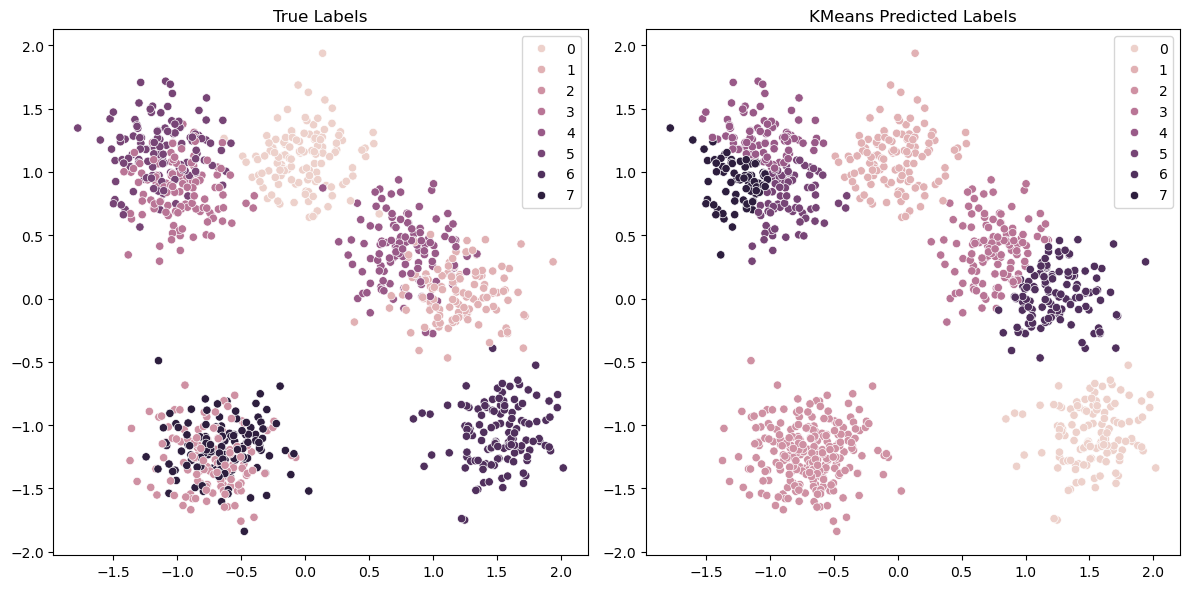

In [3]:
# Plot the data

# plot the clusters
dims = X.shape[1]
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)
    
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with true labels and KMeans labels
if dims > 2:
    print("Using PCA for dimensionality reduction")
    sns.scatterplot(ax=axes[0], x=embed_X[:, 0], y=embed_X[:, 1], hue=true_y, legend='full')
    axes[0].set_title("True Labels")

    sns.scatterplot(ax=axes[1], x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")
else:
    sns.scatterplot(ax=axes[0], x=X[:, 0], y=X[:, 1], hue=true_y, legend='full')
    axes[0].set_title("True Labels")

    sns.scatterplot(ax=axes[1], x=X[:, 0], y=X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")

plt.tight_layout()
plt.show()

In [4]:
def pickle_cfs(cf_obj):
    name = cf_obj['name']
    p = pathlib.Path(f'./testdata/cfs/{data_set}/{name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(cf_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_res(res_obj, method_name):
    p = pathlib.Path(f'./testdata/eval/{data_set}/{method_name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(res_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Cross testing of methods

## Baseline (Baycon)

In [4]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline (BayCon)",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (775) CFs (0)
Re-training surrogate model with data size: 775
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (3) Unique overall (3)
Generated random instances: (3705)
Predicted top: 20 Counterfactuals: 1
Found new best [-1.53404353 -1.2762055   1.02386151 -1.20586852  1.24505364  0.63692132
  1.34484871 -0.76554336 -0.59371141 -1.09969217 -0.63476043 -0.6066658
  1.28701622  0.66637898  0.40669019 -0.18712594  0.02308669  1.05080849
  1.15318799  0.00419713  1.6892219  -0.98638119  0.30912935 -1.0480379
  1.75481236 -0.11364664 -0.12755887 -0.14627009  0.04083972  0.88384682], with fitness score 0.4132 (X 0.82631 Y 1.0 F 0.5), oversampling
Known alternatives: 795
Best instance score 0.4132 (X 0.82631 Y 1.

KeyboardInterrupt: 

## Baseline (DICE)

In [ ]:
from lib.baseline import baseline_explainer
from lib.dice import dice_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = dice_explainer(10)
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline (DiCE)",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:11<00:00, 71.63s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:14<00:00, 74.34s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


  0%|          | 0/1 [02:33<?, ?it/s]


KeyboardInterrupt: 

## Baycon - Model Agnostic

In [ ]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - Model Agnostic",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (773) CFs (728)
Re-training surrogate model with data size: 773
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (143) Unique overall (143)
Generated random instances: (3728)
Predicted top: 20 Counterfactuals: 20
Found new best [ 0.06274896 -0.80508343  1.24104426 -1.20586852  1.32650383  1.11461231
 -0.59610144  1.82802799 -0.59371141  1.91835712 -0.86141758 -1.14385933
 -0.7485156  -0.69021737  0.40669019 -0.18712594  0.02308669 -0.22646693
 -0.41920995  0.36528867 -1.37527439 -0.98638119 -1.27427429 -1.0480379
  0.43370267 -0.11364664 -0.12755887 -0.14627009  0.04083972  0.98386255], with fitness score 0.3011 (X 0.91796 Y 0.41 F 0.8), oversampling
Known alternatives: 793
Best instance score 0.3011 (X 0.91796 Y 0.41 F 0.8), found on epoch: 1

## Baycon - Kmeans

In [ ]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[0]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - KMeans",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
[0.98649786 0.49202131 1.01866689 0.97479724 0.5871176  1.014073
 1.14492245 1.17028266 0.60339021 0.22927434 0.86311672 0.04416341
 0.86446528 0.8137762  0.01228944 0.69281919 0.63976499 0.77166695
 0.13798752 0.40384985 1.05221312 0.51705679 1.07769473 1.01391704
 0.59804381 0.95285513 1.05144274 1.15328841 0.5994129  0.61362004]
2.0251859532156713
18.549947321332983
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (776) CFs (776)
Re-training surrogate model with data size: 776
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (26) Unique overall (26)
Generated random instances: (3731)
Predicted top: 20 Counterfactuals: 20
Found new best [-1.53404353 -0.80508343  0.27923496 -1.20586852  1.32650383 -0.42320519
 -0.59610144 -0.76554336 -0.59371141  1.91835712 -0.86141758 -1.14385933
 -0.74851

## CFDE

In [ ]:
cfde_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde = {
    "name": "CFDE",
    "counterfactuals": cfde_cfs
}

pickle_cfs(cfde)

res, _ = run(cfde, centers, X, y, runtimes)
pickle_res(res, cfde['name'])

Starting on: CFDE
Removing invalid counterfactuals!!!


## CFAE

In [ ]:
cfae_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae = {
    "name": "CFAE",
    "counterfactuals": cfae_cfs
}

pickle_cfs(cfae)

res, _ = run(cfae, centers, X, y, runtimes)
pickle_res(res, cfae['name'])

Starting on: CFAE
Removing invalid counterfactuals!!!


## NeighborSearch

In [ ]:
ns_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    runtimes.append(time.time() - s)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

pickle_cfs(nfs)

res, _ = run(nfs, centers, X, y,runtimes)
pickle_res(res, nfs['name'])

Starting on: NeighborSearch
Removing invalid counterfactuals!!!


## Dice Mod

In [ ]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
from lib.util import sparsity_fix


def runner(eps):
    dice_cfs = []
    runtimes = []
    for cf in cfs:
        instance = X[cf.instance].reshape(1, -1)
        s = time.time()
        gainer = Gainer(centers, X, cf.target, instance, eps=eps)
        dice_cf = np.array([adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]])
        runtimes.append(time.time() - s)
        # print(dice_cf.shape)
        # print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
        dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

    # centers = km.cluster_centers_
    # dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
    # print(dists)

    name = f'GradCF (eps={eps})'

    dice_mod = {
        "name": name,
        "counterfactuals": dice_cfs
    }

    pickle_cfs(dice_mod)

    res, _ = run(dice_mod, centers, X, y, runtimes)
    pickle_res(res, dice_mod['name'])

    runtimes_fix = []
    dice_cfs_fixed =  []
    for i,cf in enumerate(dice_cfs):
        s = time.time()
        fixed = sparsity_fix(cf.cf, X[cf.instance, :].reshape(1, -1), X, km)
        runtimes_fix.append(runtimes[i] + (time.time() - s))
        new_cf = CounterfactualData(
            fixed, 
            cf.instance, cf.target, cf.instance_label
        )
        dice_cfs_fixed.append(new_cf)

    dice_mod_sparsity_fix = {
        "name": f"GradCF (eps={eps}) (sparsity fixed)",
        "counterfactuals": dice_cfs_fixed
    }

    pickle_cfs(dice_mod_sparsity_fix)

    res, _ = run(dice_mod_sparsity_fix, centers, X, y, runtimes_fix)
    pickle_res(res, dice_mod_sparsity_fix['name'])

for eps in [0, 0.1, 0.25, 0.5, 0.75, 1]:
    runner(eps)

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 110, score: 0.8499335234278281
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 112, score: 0.8611025893181288
Starting on: dice_mod (eps=0)
Removing invalid counterfactuals!!!
Original counterfactual: [[ 9.74676977e-01 -2.31911162e-01  9.86041729e-01  5.93292280e-01
   3.83011652e-01  2.13809776e-01  2.90726243e-01  3.74388768e-01
   4.72675083e-04  1.04964333e+00  1.44199799e-01 -5.62171675e-01
   1.02558036e-01  3.88193232e-02 -2.74541672e-01  7.64683156e-01
   9.45570082e-01  6.12900042e-01  2.79335688e-01  6.92113169e-01
   9.05913352e-01 -3.02125557e-01  8.52953763e-01  5.09634255e-01
   1.12381660e+00  6.40893250e-01  4.83179230e-01  3.95977701e-01
   7.25980815e-01  3.18987659e-01]]
instance: [[-1.53404353 -0.80508343 -1.48816212 -1.20586852  1.32650383 -0.42320519
  -0.59610144 -0.76554336 -0.59371141  1.91835712 -0.86141758 -1.14385933
  -0.7485156  -0.69021737  0.40669019 -0.18712594  0.02308669 -0.22646693
  -0.41920995  0.00419713 -1.375274

## Dice Mod - Random

In [ ]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
import torch

dice_cfs = []
count = 10
runtimes = []
torch.manual_seed(42)

for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    s = time.time()
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([random_opt(instance, gainer.gain)[0][0]  for _ in range(count)])
    runtimes.append(time.time() - s)
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod_random",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y, runtimes)
pickle_res(res, dice_mod['name'])

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 158, score: 0.38836097362743666
iter: 170, score: 0.8422174023427769
iter: 169, score: 0.8389909828037
iter: 164, score: 0.34332993273121276
iter: 142, score: 0.29809490774811453
iter: 164, score: 0.4117129350041305
iter: 153, score: 0.8427608786606812
iter: 161, score: 0.3772843409351361
iter: 160, score: 0.3846758671831146
iter: 160, score: 0.359275385881189
(10, 30)
[array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([1], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 168, score: 0.8638494404523932
iter: 161, score: 0.374928098824354
iter: 160, score: 0.8618315495630952
iter: 156, score: 0.7077493119923696
iter: 169, score: 0.8634632668602215
iter: 166, score: 0.8612864373485751
iter: 158, score: 0.428169033365147
iter: 154, score: 0.378657644870411
iter: 17

## threshold tree / imm

In [5]:
from lib.tgcf_dtc import TGCF_dtc
from lib.tgcf_imm import TGCF_imm

tt_dtc_cfs = []
runtimes_dtc = []

tt_dtc_prime_cfs = []
runtimes_prime_dtc = []

tt_imm_cfs = []
runtimes_imm = []

tt_imm_prime_cfs = []
runtimes_prime_imm = []

tt_rf_cfs = []
runtimes_rf = []

tt_dtc_tree_cfs = []
runtimes_dtc_tree = []

tt_prime_dtc_tree_cfs = []
runtimes_prime_dtc_tree = []

# -------------------------------------------------------------------------
# Threshold Tree DTC

tgcf_dtc = TGCF_dtc(km, centers, X, y)
s = time.time()
tgcf_dtc.fit(False)
dtc_train_time = time.time() - s
print(f"dtc train time: {dtc_train_time}")
for cf in cfs:
    # DTC
    s = time.time()
    tt_cf = tgcf_dtc.find_counterfactuals(X[cf.instance], cf.target, False)
    runtimes_dtc.append(time.time() - s)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    # Plausibility Fix
    s = time.time()
    tt_cf_prime = tgcf_dtc.plausibility_fix(tt_cf, X[cf.instance], cf.target)
    runtimes_prime_dtc.append(runtimes_dtc[-1] + time.time() - s)
    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

runtimes_dtc[0] += dtc_train_time
runtimes_prime_dtc[0] += dtc_train_time

tt_dtc = {
    "name": "TGCF_DTC",
    "counterfactuals": tt_dtc_cfs
}
pickle_cfs(tt_dtc)

res, _ = run(tt_dtc, centers, X, y, runtimes_dtc)
pickle_res(res, tt_dtc['name'])

tt_dtc_prime = {
    "name": "TGCF_DTC'",
    "counterfactuals": tt_dtc_prime_cfs
}
pickle_cfs(tt_dtc_prime)

res, _ = run(tt_dtc_prime, centers, X, y, runtimes_prime_dtc)
pickle_res(res, tt_dtc_prime['name'])

# -------------------------------------------------------------------------
# Threshold Tree DTC Fidelity

tgcf_dtc_fidelity = TGCF_dtc(km, centers, X, y)
s = time.time()
tgcf_dtc_fidelity.fit(True)
dtc_train_time = time.time() - s
print(f"dtc (FIDELITY) train time: {dtc_train_time}")
for cf in cfs:
    # DTC Fidelity
    s = time.time()
    tree_cfs = tgcf_dtc_fidelity.find_counterfactuals(X[cf.instance], cf.target, True)
    runtimes_dtc_tree.append(time.time() - s)
    cf_data = CounterfactualData(tree_cfs, cf.instance, cf.target, cf.instance_label)
    tt_dtc_tree_cfs.append(cf_data)

    # Plausibility Fix
    s = time.time()
    tree_cfs_prime = tgcf_dtc_fidelity.plausibility_fix(tree_cfs, X[cf.instance], cf.target)
    runtimes_prime_dtc_tree.append(runtimes_dtc_tree[-1] + time.time() - s)
    cf_data = CounterfactualData(tree_cfs_prime, cf.instance, cf.target, cf.instance_label)
    tt_prime_dtc_tree_cfs.append(cf_data)

runtimes_dtc_tree[0] += dtc_train_time
runtimes_prime_dtc_tree[0] += dtc_train_time

tt_dtc_tree = {
    "name": "TGCF_DTC_Fidelity",
    "counterfactuals": tt_dtc_tree_cfs
}
pickle_cfs(tt_dtc_tree)

res, _ = run(tt_dtc_tree, centers, X, y, runtimes_dtc_tree)
pickle_res(res, tt_dtc_tree['name'])

tt_prime_dtc_tree = {
    "name": "TGCF_DTC_Fidelity'",
    "counterfactuals": tt_prime_dtc_tree_cfs
}
pickle_cfs(tt_prime_dtc_tree)

res, _ = run(tt_prime_dtc_tree, centers, X, y, runtimes_prime_dtc_tree)
pickle_res(res, tt_prime_dtc_tree['name'])

# -------------------------------------------------------------------------
# Threshold Tree IMM

tgcf_imm = TGCF_imm(km, centers, X, y)
s = time.time()
tgcf_imm.fit()
imm_train_time = time.time() - s
print(f"IMM train time: {imm_train_time}")
for cf in cfs:
    # IMM
    s = time.time()
    tt_imm_cf = tgcf_imm.find_counterfactuals(X[cf.instance], cf.target)
    runtimes_imm.append(time.time() - s)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    # Plausibility Fix
    s = time.time()
    tt_imm_cf_prime = tgcf_imm.plausibility_fix(tt_imm_cf, X[cf.instance], cf.target)
    runtimes_prime_imm.append(runtimes_imm[-1] + time.time() - s)
    tt_imm_prime_cfs.append(cf_data)
    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)

runtimes_imm[0] += imm_train_time
runtimes_prime_imm[0] += imm_train_time

tt_imm = {
    "name": "TGCF_IMM",
    "counterfactuals": tt_imm_cfs
}
pickle_cfs(tt_imm)

res, _ = run(tt_imm, centers, X, y, runtimes_imm)
pickle_res(res, tt_imm['name'])

tt_imm_prime = {
    "name": "TGCF_IMM'",
    "counterfactuals": tt_imm_prime_cfs
}
pickle_cfs(tt_imm_prime)

res, _ = run(tt_imm_prime, centers, X, y, runtimes_prime_imm)
pickle_res(res, tt_imm_prime['name'])


DTC accuracy: 0.999
dtc train time: 0.017309188842773438
Starting on: TGCF_DTC
Removing invalid counterfactuals!!!
Starting on: TGCF_DTC'
Removing invalid counterfactuals!!!
DTC accuracy: 0.999
dtc (FIDELITY) train time: 0.019289731979370117
Starting on: TGCF_DTC_Fidelity
Removing invalid counterfactuals!!!
Starting on: TGCF_DTC_Fidelity'
Removing invalid counterfactuals!!!
IMM train time: 0.030372142791748047
Starting on: TGCF_IMM
Removing invalid counterfactuals!!!
Starting on: TGCF_IMM'
Removing invalid counterfactuals!!!


# Loading method counterfactuals

In [6]:
methods_to_analyze = [] # Runs all methods when empty
metrics_active = [] # Uses all metrics when empty

methods = []
base_path = f'./testdata/cfs/{data_set}'
for p in os.listdir(base_path):
    with open(os.path.join(base_path, p), 'rb') as file:
        cf_obj = pickle.load(file)
        if cf_obj['name'] not in methods_to_analyze and methods_to_analyze != []:
            continue
        methods.append(cf_obj)

methodNames = [m['name'] for m in methods]
print('\n'.join(sorted(methodNames)))

results = {}
base_path = f'./testdata/eval/{data_set}'
for m in methods:
    with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
        results[m['name']] = res

TGCF_DTC
TGCF_DTC'
TGCF_DTC_Fidelity
TGCF_DTC_Fidelity'
TGCF_IMM
TGCF_IMM'


# Print & plot evaluation results

In [7]:
max_name_length = max(len(m) for m in methodNames)
mean_results = []

def rep(m):
    return m.replace("-", "_").replace(" ", "_")

for i, n in enumerate(returnNames()):
    if n not in metrics_active and metrics_active != []:
        continue
    row = {}
    for m in methodNames:
        # Get the results for the current method m and metric i
        # so res = list of results, one number for each cf for each instance we're explaining

        # print(f"i: {i}, m: {m}, n: {n}")
        res = [row[i] for row in results[m]]

        flat = []
        for metric in res:
            # if m == "ThresholdTree_fidelity_Tree_Fix": print(n, metric)
            try:
                flat.extend(metric)
            except TypeError:

                # Invalidation and correction metrics return None if no valid/invalid CFs were found
                if metric != None:
                    flat.append(metric)


        mean = np.mean(flat)
        var = np.var(flat)
        stddev = np.std(flat)
        if n == "PercentExplained":
            row[rep(m)] = f"{mean:.2f}"
        else:
            row[rep(m)] = f"{mean:.2f} ± {stddev:.2f}"
        
        # We are getting the mean of ALL CFs for ALL instances
        # # Get mean for each instance first
        # instance_means = []
        # for j in range(cf_amount):
        #     mean = np.mean(res[j])
            
        #     # If no CFs were found, res[j] is empty, and np.mean() returns NaN
        #     if not np.isnan(mean):
        #         instance_means.append(mean)

        # Finally, get the means of the instance means. If this is a NaN, 
        # no VALID CFs were found for any instance

    mean_results.append(row)

base_filter = [rep(m) for m in methodNames]
dice_filter = [rep(m) for m in methodNames if "grad" in m.lower()]
tree_filter = [rep(m) for m in methodNames if "tgcf" in m.lower()]

filter = tree_filter

filter.sort()
print('\n'.join(filter))
if metrics_active == []:
    names = returnNames()
else:
    names = metrics_active

if "ValidCFs" in names:
    validcfs_index = names.index("ValidCFs")
    names[validcfs_index] = "# Valid CFs"

mean_results_df = pd.DataFrame(mean_results, index=names)
mean_results_df[filter]

TGCF_DTC
TGCF_DTC'
TGCF_DTC_Fidelity
TGCF_DTC_Fidelity'
TGCF_IMM
TGCF_IMM'


,TGCF_DTC,TGCF_DTC',TGCF_DTC_Fidelity,TGCF_DTC_Fidelity',TGCF_IMM,TGCF_IMM'
Similarity,1.56 ± 0.79,1.75 ± 0.75,1.69 ± 0.79,1.89 ± 0.76,1.25 ± 0.40,1.25 ± 0.40
Sparsity,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.40 ± 0.20,0.40 ± 0.20
Plausibility,-1.36 ± 0.36,-1.07 ± 0.18,-1.44 ± 0.41,-1.04 ± 0.12,-1.97 ± 0.34,-1.97 ± 0.34
Validity,0.66 ± 0.36,0.96 ± 0.10,0.75 ± 0.24,0.97 ± 0.09,0.20 ± 0.40,0.20 ± 0.40
Diversity,0.51 ± 0.39,0.30 ± 0.40,0.42 ± 0.34,0.09 ± 0.12,1.07 ± 0.02,1.08 ± 0.02
Invalidation,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00
Correction,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00
Runtime,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.01,0.00 ± 0.01
PercentExplained,0.88,1.00,1.00,1.00,0.20,0.20
# Valid CFs,2.40 ± 1.50,3.24 ± 1.36,3.08 ± 1.13,4.00 ± 0.98,0.20 ± 0.40,0.20 ± 0.40


In [8]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for m in methodNames:
        res = results[m]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

In [9]:
for i in range(0):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

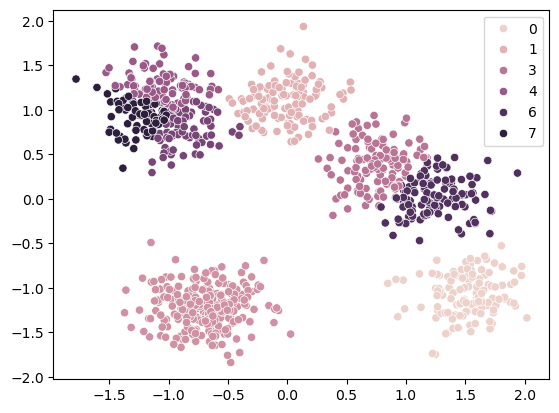

In [10]:
pca = PCA(n_components=2)
if X.shape[1] > 2:
    embed_X = pca.fit_transform(X)
else:
    embed_X = X
    
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
plt.show()

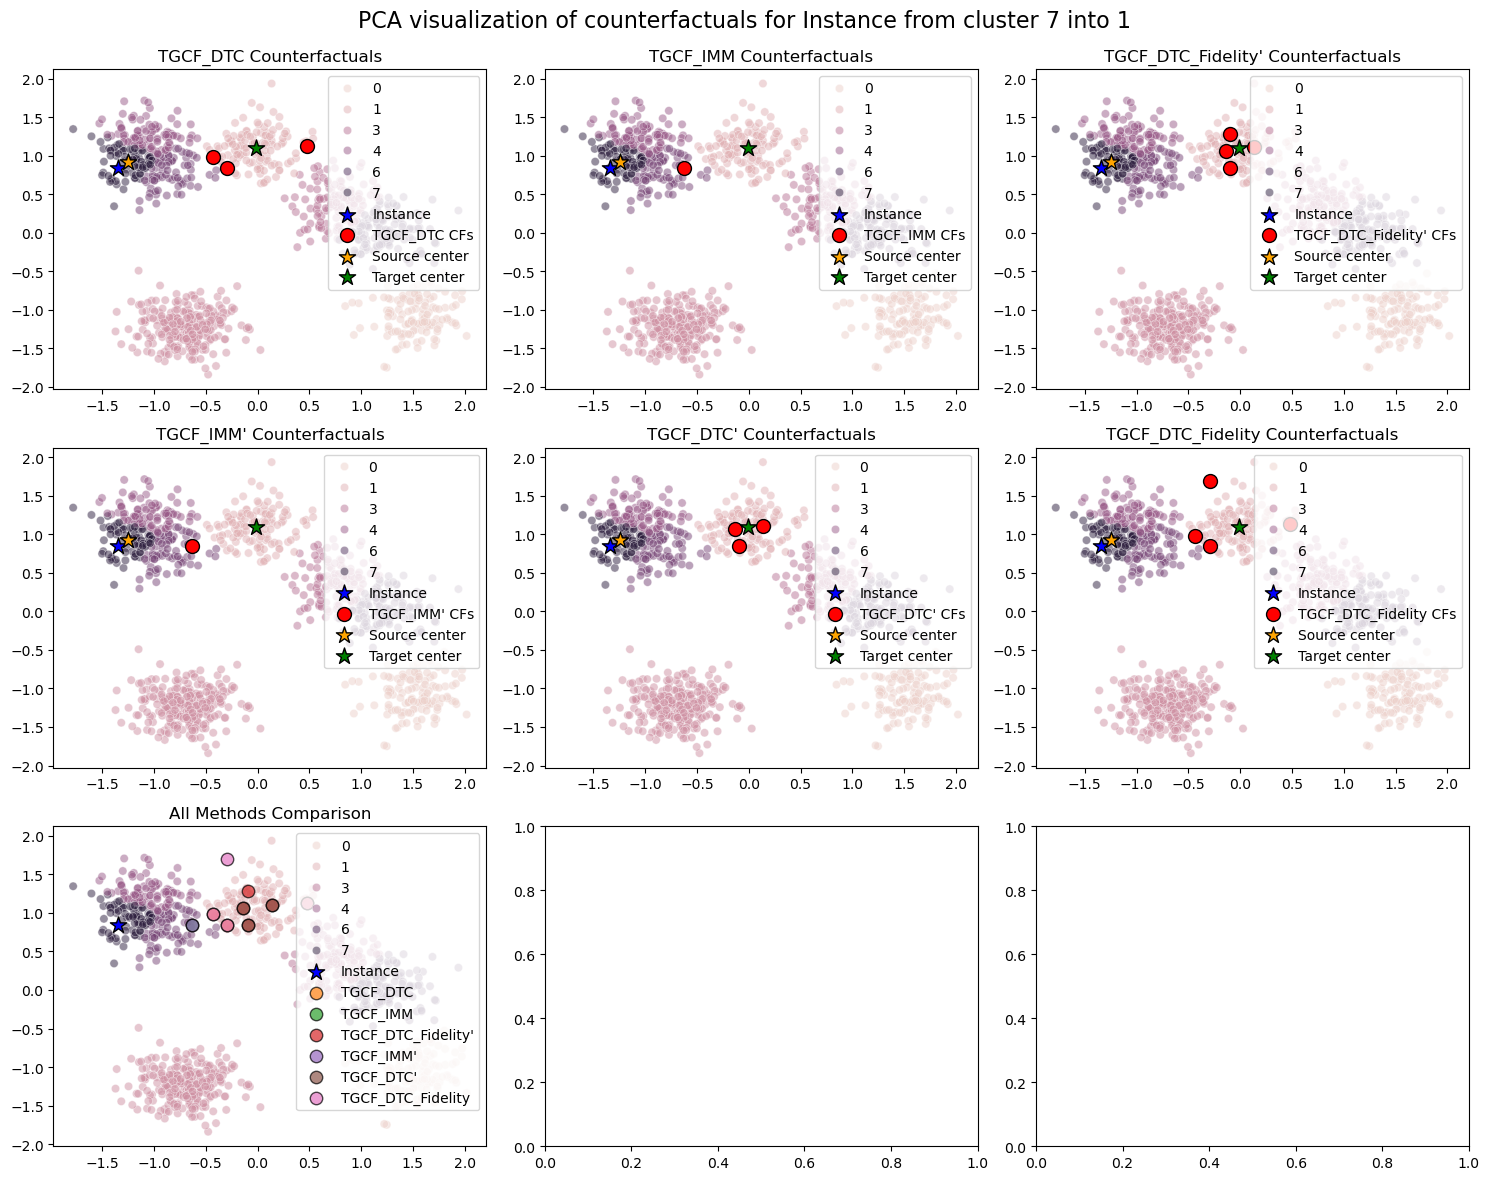

In [11]:
cf_n = 2

# Calculate the number of methods to determine grid size
n_methods = len(methods)
# Create a square-ish grid with enough cells for all methods plus one for comparison
rows = int(np.ceil(np.sqrt((n_methods + 1) / 1.5)))
cols = int(np.ceil((n_methods + 1) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs = axs.flatten()

cffDict = methods

ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

if X.shape[1] > 2:
    instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])
    methods_embedded = [
        (m['name'], pca.transform(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
    centers_embedded = pca.transform(centers)
else:
    instance_embedded = X[[cffDict[0]['counterfactuals'][cf_n].instance]]
    methods_embedded = [
        (m['name'], np.array(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
    centers_embedded = centers

# Base scatterplot of the data

for i, (name, embed) in enumerate(methods_embedded):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].scatter(centers_embedded[ins_c,0], centers_embedded[ins_c, 1], color='orange', s=150, 
                  marker='*', label='Source center', zorder=5, edgecolor='black')
    axs[i].scatter(centers_embedded[target_c,0], centers_embedded[target_c, 1], color='green', s=150, 
                  marker='*', label='Target center', zorder=5, edgecolor='black')
    
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods_embedded)])
axs[len(methods_embedded)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
for i, (name, embed) in enumerate(methods_embedded):
    axs[len(methods_embedded)].scatter(embed[:, 0], embed[:, 1], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods_embedded)].set_title("All Methods Comparison")
axs[len(methods_embedded)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()